In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

from tensorflow.keras.utils import to_categorical

In [2]:
from tensorflow.keras.models import model_from_json

In [3]:
import plotting
from sklearn.metrics import accuracy_score

In [4]:
data_loc = '/gpfs/slac/atlas/fs1/d/rafaeltl/public/ML/L1RNN/datasets_2020_ff/'
file_str = 'Jan06_FlavFix_smear_1_std_xtd_zst.h5'

In [5]:
f5 = h5py.File(data_loc+file_str, 'r')

In [6]:
x_test = np.array( f5['x_test'] )
y_test = to_categorical ( np.array( f5['y_test'] ) )

In [9]:
# model_name = 'rnn_LSTM_50_10_nomask_LSTMKIvs_KRl20.0001'
# model_name = 'rnn_GRU_50_10_nomask_LSTMKIvs_KRl20.0001'
# model_name = 'rnn_LSTM_50_10_nomask_LSTMKIvs_KRl10.001l20.0001'



model_name = 'rnn_LSTM_20_10_nomask_KIvs_KRl2.0_recAct.sigmoid'

In [10]:
arch_json = open('/sdf/home/r/rafaeltl/home/rafaeltl/ML/L1BTag/Mar28/L1BTag/code/hls/notebooks/keras/model_'+model_name+'_arch.json', 'r').read()
model = model_from_json(arch_json)
model.load_weights(f'/sdf/home/r/rafaeltl/home/rafaeltl/ML/L1BTag/Mar28/L1BTag/code/hls/notebooks/keras/model_{model_name}_weights.h5')

In [11]:
y_keras = model.predict(x_test, batch_size=2**10)

In [12]:
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))

Accuracy: 0.7239680691834359


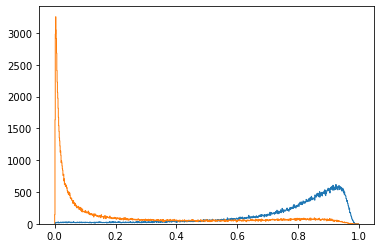

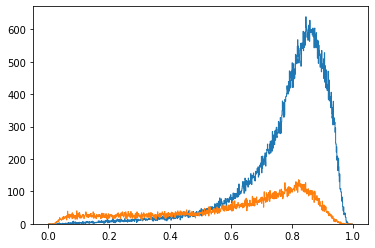

In [13]:
pb_b = y_keras[:,0] [y_test[:,0] == 1]
pc_b = y_keras[:,1] [y_test[:,0] == 1]
pl_b = y_keras[:,2] [y_test[:,0] == 1]
    
pc_c = y_keras[:,1] [y_test[:,1] == 1]
pb_c = y_keras[:,0] [y_test[:,1] == 1]
    
pl_l = y_keras[:,2] [y_test[:,2] == 1]
pb_l = y_keras[:,0] [y_test[:,2] == 1]

plt.Figure()

plt.hist( pb_b/(pb_b+pl_b), range=(0,1), bins=1000, histtype='step' )
plt.hist( pb_l/(pb_l+pl_l), range=(0,1), bins=1000, histtype='step' )

plt.show()


plt.Figure()

plt.hist( pb_b/(pb_b+pc_b), range=(0,1), bins=1000, histtype='step' )
plt.hist( pb_c/(pb_c+pc_c), range=(0,1), bins=1000, histtype='step' )

plt.show()

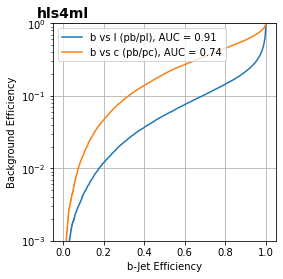

In [14]:
plt.figure(figsize=(4,4))
_ = plotting.makeRoc(y_test, y_keras)

In [15]:
import hls4ml

In [16]:
config = hls4ml.utils.config_from_keras_model(model, granularity='model')
config_resource = hls4ml.utils.config_from_keras_model(model, granularity='model')
config_reuse = hls4ml.utils.config_from_keras_model(model, granularity='model')

Interpreting Model
Topology:
Layer name: input_2, layer type: Input
Layer name: lstm1, layer type: LSTM
  -> Activation (tanh), layer name: lstm1
Layer name: dense_0, layer type: Dense
  -> Activation (relu), layer name: dense_0
Layer name: output_sigmoid, layer type: Dense
  -> Activation (softmax), layer name: output_sigmoid
Interpreting Model
Topology:
Layer name: input_2, layer type: Input
Layer name: lstm1, layer type: LSTM
  -> Activation (tanh), layer name: lstm1
Layer name: dense_0, layer type: Dense
  -> Activation (relu), layer name: dense_0
Layer name: output_sigmoid, layer type: Dense
  -> Activation (softmax), layer name: output_sigmoid
Interpreting Model
Topology:
Layer name: input_2, layer type: Input
Layer name: lstm1, layer type: LSTM
  -> Activation (tanh), layer name: lstm1
Layer name: dense_0, layer type: Dense
  -> Activation (relu), layer name: dense_0
Layer name: output_sigmoid, layer type: Dense
  -> Activation (softmax), layer name: output_sigmoid


In [17]:
config_resource['Model']['Strategy'] = 'Resource'

In [18]:
reusefactor = 64
config_reuse['Model']['ReuseFactor'] = reusefactor
config_resource['Model']['ReuseFactor'] = reusefactor

In [19]:
model_suffix = '_modPrec16.6'

In [20]:
project_name = f'model_{model_name}{model_suffix}'
project_name_resource = f'model_{model_name}{model_suffix}_resource'
project_name_reuse = f'model_{model_name}{model_suffix}_reuse{reusefactor}'

In [21]:
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir=f'{project_name}/hls4ml_prj',
                                                       fpga_part='xcu250-figd2104-2L-e')

Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, current shape: [[None, 15, 6]]
Layer name: lstm1, layer type: LSTM, current shape: [[None, 15, 6]]
Layer name: dense_0, layer type: Dense, current shape: [[None, 1, 20]]
Layer name: output_sigmoid, layer type: Dense, current shape: [[None, 10]]
Creating HLS model


In [22]:
hls_model_resource = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config_resource,
                                                       output_dir=f'{project_name_resource}/hls4ml_prj',
                                                       fpga_part='xcu250-figd2104-2L-e')

Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, current shape: [[None, 15, 6]]
Layer name: lstm1, layer type: LSTM, current shape: [[None, 15, 6]]
Layer name: dense_0, layer type: Dense, current shape: [[None, 1, 20]]
Layer name: output_sigmoid, layer type: Dense, current shape: [[None, 10]]
Creating HLS model


In [23]:
config_reuse

{'Model': {'Precision': 'ap_fixed<16,6>',
  'ReuseFactor': 64,
  'Strategy': 'Latency'}}

In [24]:
hls_model_reuse = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config_reuse,
                                                       output_dir=f'{project_name_reuse}/hls4ml_prj',
                                                       fpga_part='xcu250-figd2104-2L-e')

Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, current shape: [[None, 15, 6]]
Layer name: lstm1, layer type: LSTM, current shape: [[None, 15, 6]]
Layer name: dense_0, layer type: Dense, current shape: [[None, 1, 20]]
Layer name: output_sigmoid, layer type: Dense, current shape: [[None, 10]]
Creating HLS model


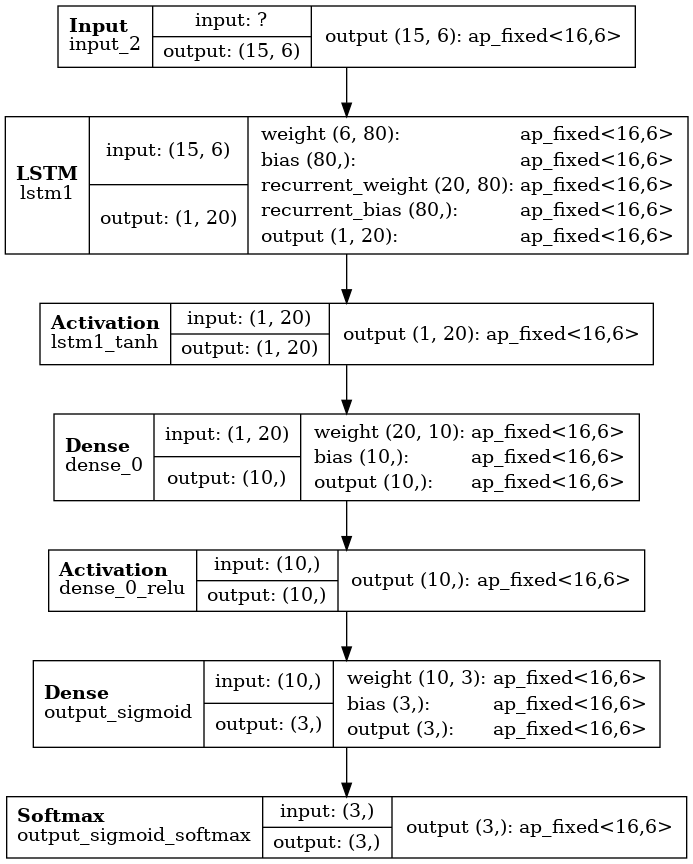

In [25]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)
hls4ml.utils.plot_model(hls_model_resource, show_shapes=True, show_precision=True, to_file=None)
hls4ml.utils.plot_model(hls_model_reuse, show_shapes=True, show_precision=True, to_file=None)

In [26]:
hls_model.compile()

Writing HLS project
Done


In [27]:
hls_model_resource.compile()

Writing HLS project
Done


In [28]:
hls_model_reuse.compile()

Writing HLS project
Done


In [29]:
x_test_cont = np.ascontiguousarray(x_test[:10000,:,:])

In [30]:
y_hls = hls_model.predict(x_test_cont)

In [31]:
y_hls_resource = hls_model_resource.predict(x_test_cont)

In [32]:
y_hls_reuse = hls_model_reuse.predict(x_test_cont)

In [33]:
y_hls_resource, y_hls_reuse, y_hls, y_keras

(array([[0.23535156, 0.32226562, 0.53222656],
        [0.18457031, 0.25292969, 0.64550781],
        [0.18457031, 0.18457031, 0.6875    ],
        ...,
        [0.17382812, 0.32421875, 0.53515625],
        [0.17382812, 0.32421875, 0.53515625],
        [0.25292969, 0.32421875, 0.50292969]]),
 array([[0.52734375, 0.21972656, 0.34082031],
        [0.60058594, 0.25      , 0.16113281],
        [0.00976562, 0.05371094, 0.95507812],
        ...,
        [0.49609375, 0.20605469, 0.36328125],
        [0.24902344, 0.19433594, 0.5625    ],
        [0.03027344, 0.07910156, 0.90820312]]),
 array([[0.52734375, 0.21972656, 0.34082031],
        [0.60058594, 0.25      , 0.16113281],
        [0.00976562, 0.05371094, 0.95507812],
        ...,
        [0.49609375, 0.20605469, 0.36328125],
        [0.24902344, 0.19433594, 0.5625    ],
        [0.03027344, 0.07910156, 0.90820312]]),
 array([[0.50790846, 0.1842199 , 0.3078716 ],
        [0.65485644, 0.21484788, 0.13029568],
        [0.00327842, 0.02213833, 0.

Keras  Accuracy: 0.7239680691834359
hls4ml Accuracy: 0.701


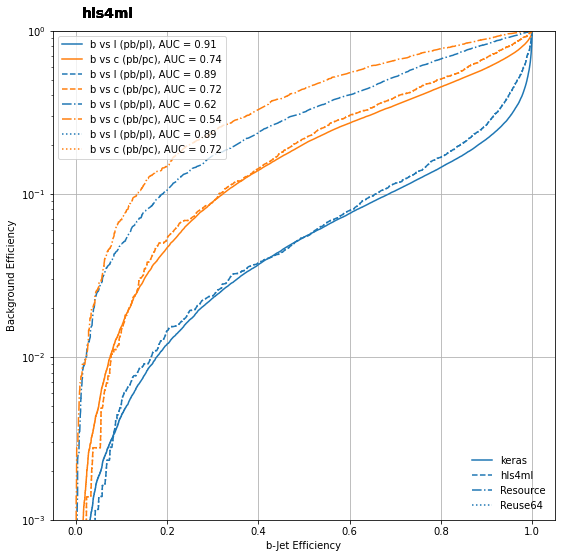

In [34]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test[:10000], axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras)

plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test[:10000], y_hls, linestyle='--')

plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test[:10000], y_hls_resource, linestyle='-.')

plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test[:10000], y_hls_reuse, linestyle=':')


from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--'),
         Line2D([0], [0], ls='-.'),
         Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['keras', 'hls4ml', 'Resource', f'Reuse{reusefactor}'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

In [35]:
import myprofiling

Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, current shape: [[None, 15, 6]]
Layer name: lstm1, layer type: LSTM, current shape: [[None, 15, 6]]
Layer name: dense_0, layer type: Dense, current shape: [[None, 1, 20]]
Layer name: output_sigmoid, layer type: Dense, current shape: [[None, 10]]
Creating HLS model
Profiling weights (before optimization)
Weights for lstm1 are only zeros, ignoring.
Profiling weights (final / after optimization)
Weights for lstm1 are only zeros, ignoring.
Profiling activations (before optimization)
   input_2
   lstm1
   dense_0
   output_sigmoid
Profiling activations (final / after optimization)
Recompiling myproject with tracing
Writing HLS project
Done


RuntimeError: HLSModel must have tracing on for at least 1 layer (this can be set in its config)

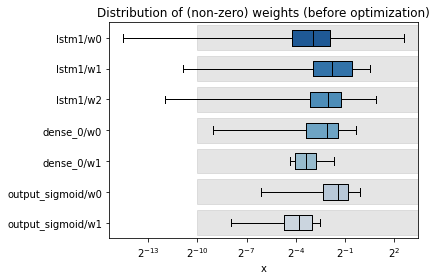

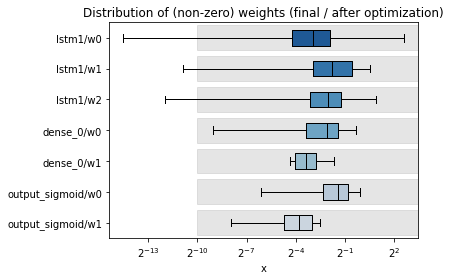

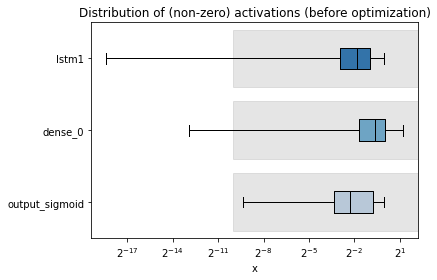

In [36]:
myprofiling.numerical(model=model, hls_model=hls_model, X=x_test[:1000])

In [ ]:
import os
os.environ['PATH'] = '/gpfs/slac/atlas/fs1/d/rafaeltl/public/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
os.environ['LM_LICENSE_FILE'] = '2100@rdlic1:2100@rdlic2:2100@rdlic3'

In [ ]:
hls_model.build(csim=False)

In [ ]:
hls_model_resource.build()

In [ ]:
hls_model_reuse.build()

In [ ]:
from contextlib import redirect_stdout

In [ ]:
with open('out.txt', 'w') as f:
    with redirect_stdout(f):
        hls4ml.report.read_vivado_report(f'{project_name}/hls4ml_prj')

In [ ]:
print(rep)